<a href="https://colab.research.google.com/github/mrfabien/MLEE_project/blob/main/MLEE_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

A few librairies are going to be used, so let's install them. For panda, you'll need to restart the kernel to update it, otherwise it won't work.

In [1]:
# Panda version needs to be higher than 1.4.1 to extract the data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import time
from sklearn.inspection import permutation_importance

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

pd.__version__ 
%pip install pandas==1.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data preparation

Since the dataset is split into 2, one for moderate winds and the other dfor extreme winds. Let's merge them to simplify the notebook

In [2]:
# Path of the dataset

path_75 = 'df_europewinds_75.pkl'
path_95 = 'df_europewinds_95.pkl'

Let's look at the datasets

In [39]:
data_75 = pd.read_pickle(open(path_75, 'rb'))
describ_75 = data_75.describe()

In [34]:
data_95 = pd.read_pickle(open(path_95, 'rb'))
describ_95 = data_95.describe()

We need to create a new column to know whether or not it was a moderate wind or an extreme wind.

In [5]:
# Intensity 1 means extreme convective winds bursts and 0 means moderate convective bursts

data_75['intensity']=0
data_95['intensity']=1

In [6]:
# Merge the 2 dataset and separate the features from the intensity

data_merged = pd.concat((data_75,data_95))
y_all = data_merged['intensity']
X_all = data_merged.iloc[:,2:-1]

In [7]:
# Store the name of each predictor

features_names = data_merged.columns[2:-1]

# Data splitting

Two splitting of the dataset can be tested. One with train_test_split() and the other one with the 8 first years for the training, the next one for testing and the last one for validation.

In [ ]:
# Splitting of the dataset with years

'''
years_training = np.arange(0,7)
years_test = np.arange(7,8)
years_valid = np.arange(8,9)

data_training = data_merged.loc[data_merged['year'].isin(years_training)]
data_test = data_merged.loc[data_merged['year'].isin(years_test)]
data_valid = data_merged.loc[data_merged['year'].isin(years_valid)]

X_train = data_training.iloc[:,2:-1]
y_train = data_training['intensity']
X_test = data_test.iloc[:,2:-1]
y_test = data_test['intensity']
X_valid = data_valid.iloc[:,2:-1]
y_valid = data_valid['intensity']
'''

In [8]:
# Splitting the dataset into a training (64%), testing (20%), and validation set (16%)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_all, y_all, train_size=0.8)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, train_size=0.8)

# 1st algorithm : Logistic Regression


Let's try to predict the 2 classes of winds bursts with Logistic Regression on default settings

In [ ]:
# Fitting the training set 

lr_default = LogisticRegression(random_state=42)
lr_default.fit(X_train, y_train)

In [ ]:
# Prediction with the test set

prediction_lr_default = lr_default.predict(X_test)

lr_default_accuracy = accuracy_score(y_test, prediction_lr_default)

print(f"Logistic Regression model accuracy with default settings: {lr_default_accuracy:.2%}")

The accuracy is ok, around 60%, so let's try to adujst the solver by picking another one.

In [ ]:
# Fitting the training set with 'liblinear' solver. 
# The solver 'newton-cg' fits a little bit better, but the 4 solvers have roughly the same accuracy

lr_custom = LogisticRegression(solver='liblinear',
                                random_state=42)
lr_custom.fit(X_train, y_train)

In [ ]:
# Let's try a prediction with the testing set

prediction_lr_custom = lr_custom.predict(X_train)
lr_custom_accuracy = accuracy_score(y_train, prediction_lr_custom)


print(f"Logistic Regression Model accuracy with costums settings on training set: {lr_custom_accuracy:.2%}")

The accuracy is marginally better, so let's try to see the accuracy on the testing set and the validation set.

In [ ]:
# Prediction of the testing and validation set

y_pred_test_LR = lr_custom.predict(X_test)
y_pred_valid_LR = lr_custom.predict(X_valid)
print(f'Accuracy over training set: {(accuracy_score(y_test,y_pred_test_LR)):.2%} \n' 
f'Accuracy over test set: {(accuracy_score(y_valid,y_pred_valid_LR)):.2%}')

The accuracy is still not good, just above 60%. The next step is to see the prediction with the confusion matrix on the testing set.

## Confusion Matrix on the testing set
This matrix allows to see : 

*   the the true positive (1,1)
*   the true negative (0,0)
*   the false negative (0,1)
*   the false positive (1,0)

In [ ]:
# Confusion matrix on the testing set

cm = confusion_matrix(y_test, y_pred_test_LR, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Result should look like the following image:

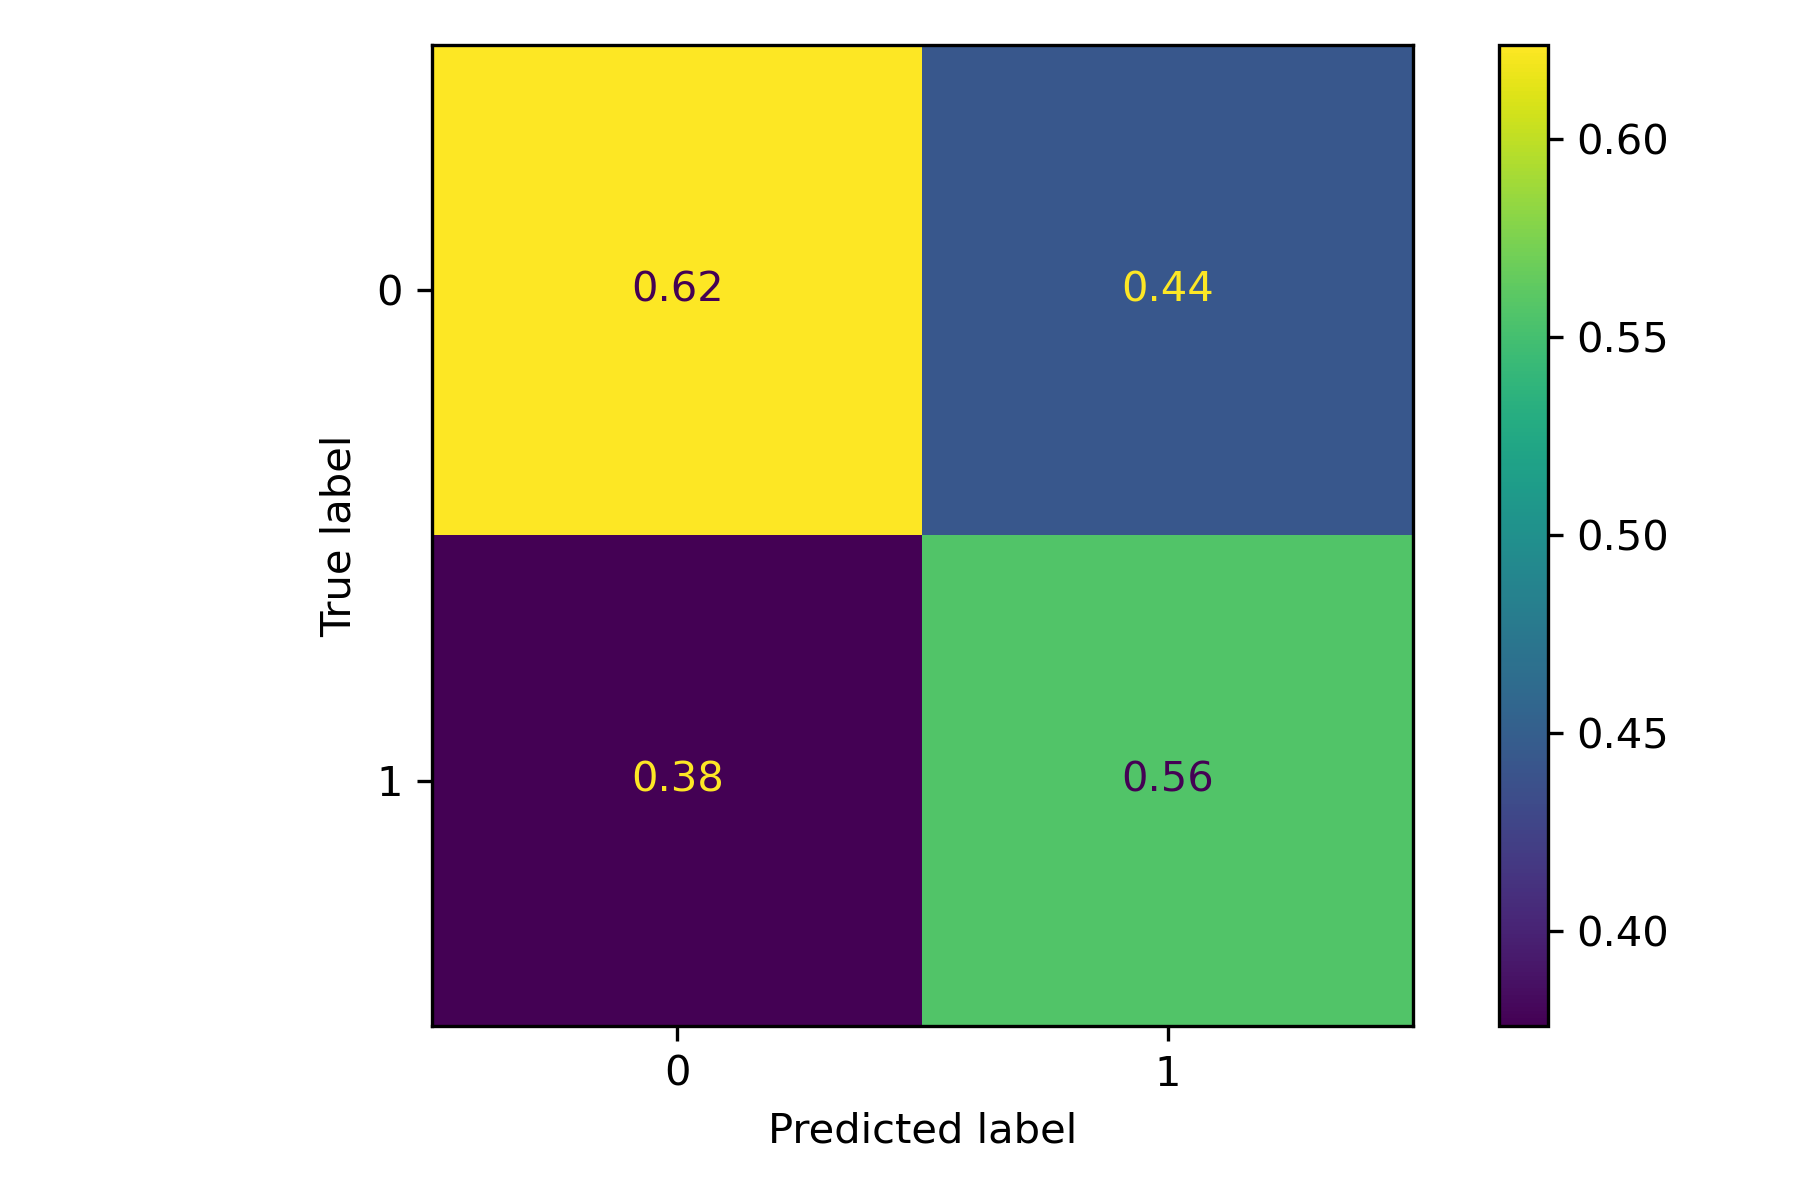

From this matrix, we can learn that the Logistic Regression predicts 44% with false positive and 38% with false negative. 

## Features permutation

The feature permutation gives an insight on which predictor is mainly used for the model. The following cell was copied from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html.


This cell mainly extract the importances of each feature and standardized them. It also check how much time it takes

In [ ]:
# Permutation of the features 

start_time = time.time()
result_LR = permutation_importance(
    lr_custom, X_test, y_test, n_repeats=20, random_state=42, n_jobs=6
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

logistic_importances = pd.Series(result_LR.importances_mean, index=features_names)

# Let's see the resutls. The higher the bar is, the more important the feature is

fig, ax = plt.subplots()
logistic_importances.plot.bar(yerr=result_LR.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on costum LR")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Logistic Regression doesn't really give strong results. Let's try Random Forest Classifier

# 2nd algorithm: Random Forest Classifier
Let's try to predict the 2 classes of winds bursts with Random Forest Classifier on default settings

In [9]:
# Fitting the training set 

rf_default = RandomForestClassifier(n_jobs = 6, random_state=42)
rf_default.fit(X_train,y_train)

RandomForestClassifier(n_jobs=6, random_state=42)

In [10]:
# Predictions of the testing set

prediction_rf_default = rf_default.predict(X_test)
rf_default_accuracy = accuracy_score(y_test, prediction_rf_default)

print(f"Random Forest model accuracy with default settings:: {rf_default_accuracy:.2%}")

Random Forest model accuracy with default settings:: 67.00%


Already, results are better than the Logistic Regression, but still under 70% of accuracy. Next step is to tune the hyperparameters

## Hyperparameters tuning

WARNING: this cell takes a long time to run (40 minutes). 4 different hyperparameters are tuned. I left the cell if you want to try it, but there's a list of the best estimators I've found after this cell.

In [ ]:
# param_grid helps to define the hyperparameters you would like to test, 
# and the ranges the hyperparameters should be in
'''
param_grid = {'max_leaf_nodes':np.arange(60,220,20),
              'min_samples_split':np.arange(5,30,5),
              'n_estimators': np.arange(50, 300, 50),
              'max_depth': [3, 10, 20, 40]}

# Then, perform the HalvingGridSearch on the RandomForest

rf_custom = HalvingGridSearchCV(RandomForestClassifier(random_state=42),param_grid,cv=10,verbose=2, n_jobs=10, random_state=42)

# Next, try a new fit with the training set

start_time = time.time()
rf_custom.fit(X_train,y_train)
elapsed_time_RF = time.time() - start_time
print(f"Elapsed time to fit the training set with tuned hyperparameters Random Forest Classifier : {elapsed_time_RF:.3f} seconds")
'''

In [15]:
# Best estimators are the following:

#print('Best estimators are the following:',rf_custom.best_estimator_)

ls_be_RF = []
'''
ls_be_RF = [rf_custom.best_params_['max_leaf_nodes'],
            rf_custom.best_params_['min_samples_split'],
            rf_custom.best_params_['n_estimators'],
            rf_custom.best_params_['max_depth']]
'''
# From the few tests I've conducted, the best estimators so far are the following:

ls_be_RF= [200, 15, 150, 10]

# Let's see the prediction from the tuned RF

rf_custom = RandomForestClassifier(max_leaf_nodes= ls_be_RF[0],
                                   min_samples_split= ls_be_RF[1],
                                   n_estimators= ls_be_RF[2],
                                   max_depth= ls_be_RF[3])
rf_custom.fit(X_train,y_train)
prediction_rf_custom = rf_custom.predict(X_train)
rf_custom_accuracy = accuracy_score(y_train, prediction_rf_custom)

print(f"RF hyperparameters tuning Model Accuracy: {rf_custom_accuracy:.2%}")

# Now let's compare it with prediction based on the training and testing set

y_pred_test_RF = rf_custom.predict(X_test)
y_pred_valid_RF = rf_custom.predict(X_valid)
print(f'Accuracy over training set: {(accuracy_score(y_test,y_pred_test_RF)):.2%} \n' 
f'Accuracy over validation set: {(accuracy_score(y_valid,y_pred_valid_RF)):.2%}')

RF hyperparameters tuning Model Accuracy: 74.27%
Accuracy over training set: 65.74% 
Accuracy over validation set: 66.48%


Results are barely better than the first try with RF, let's see the confusion matrix

## Confusion Matrix on testing test
This matrix allows us to see: 

*   the the true positive (1,1)
*   the true negative (0,0)
*   the false negative (0,1)
*   the false positive (1,0)

On the testing set.

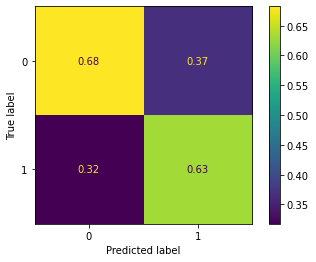

In [17]:
# Confusion matrix on the testing set

cm = confusion_matrix(y_test, y_pred_test_RF, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

## Features permutation

Since the performance are not clearly better than the LR, let's see what features are important for the RF. The following cell was copied from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html.

This cell mainly permute the features and see how the model refit them. 
It also check how much time it takes

In [18]:
# Permutation of the features and see how the model refit them

from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    rf_custom, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=features_names)

Elapsed time to compute the importances: 25.409 seconds


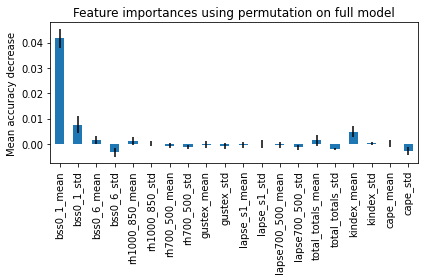

In [19]:
# Let's see the results. The higher the bar is, the more important the feature is for the model

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# 3rd algorithm: Decision Tree Classifier

The same methodology used for Random Forest is applied for this algorithm

In [21]:
# Fitting with default parameters

dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train,y_train)

# Let's see if the predictions are better than the others

prediction_dt_default = dt_default.predict(X_test)
dt_default_accuracy = accuracy_score(y_test, prediction_rf_default)

print(f"Decision Tree default settings accuracy: {dt_default_accuracy:.2%}")

DT default Model Accuracy: 67.00%


Same accuracy as the default model for Random Forest, let's try to improve it.

## Hyperparameters tuning

Only 3 different hyperparameters are tuned.

In [22]:
# param_grid helps to define the hyperparameters you would like to test, 
# and the ranges the hyperparameters should be in

param_grid2 = {'max_leaf_nodes':np.arange(60,220,20),
               'min_samples_split':np.arange(5,30,5),
               'max_depth': [3, 10, 20, 30, 40]}
dt_custom = HalvingGridSearchCV(DecisionTreeClassifier(random_state=42),param_grid2,cv=10,verbose=2, n_jobs=10)

# Next, try a new fit with the training data

start_time = time.time()
dt_custom.fit(X_train,y_train)
elapsed_time_DT = time.time() - start_time

print(f"Elapsed time to fit the training set with tuned hyperparameters DT : {elapsed_time_DT:.3f} seconds")

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 284
max_resources_: 23008
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 200
n_resources: 284
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
----------
iter: 1
n_candidates: 67
n_resources: 852
Fitting 10 folds for each of 67 candidates, totalling 670 fits
----------
iter: 2
n_candidates: 23
n_resources: 2556
Fitting 10 folds for each of 23 candidates, totalling 230 fits
----------
iter: 3
n_candidates: 8
n_resources: 7668
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 4
n_candidates: 3
n_resources: 23004
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Elapsed time to fit the training set with tuned hyperparameters DT : 38.819 seconds


In [23]:
# Best estimators are the following:

print('Best estimators are the following:',dt_custom.best_estimator_)

ls_be_DT = []
ls_be_DT = [dt_custom.best_params_['max_leaf_nodes'],
            dt_custom.best_params_['min_samples_split'],
            dt_custom.best_params_['max_depth']]

# Let's see the prediction from the tuned Decision Tree

prediction_dt_custom = dt_custom.predict(X_train)
dt_custom_accuracy = accuracy_score(y_train, prediction_dt_custom)

print(f"DT hyperparameters tuning Model Accuracy: {dt_custom_accuracy:.2%}")

# Now let's compare it with prediction based on the training and testing set

y_pred_test_DT = dt_custom.predict(X_test)
y_pred_valid_DT = dt_custom.predict(X_valid)

test_acc_DT = (accuracy_score(y_test,y_pred_test_DT))
valid_acc_DT = (accuracy_score(y_valid,y_pred_valid_DT))
print(f'Accuracy over the testing set: {(accuracy_score(y_test,y_pred_test_DT)):.2%} \n' 
f'Accuracy over the validation set: {(accuracy_score(y_valid,y_pred_valid_DT)):.2%}')

Best estimators are the following: DecisionTreeClassifier(max_depth=3, max_leaf_nodes=120, min_samples_split=10,
                       random_state=42)
DT hyperparameters tuning Model Accuracy: 63.67%
Accuracy over the testing set: 63.28% 
Accuracy over the validation set: 63.02%


Results are barely better than the default settings of the Decision Tree, let's see the confusion matrix.

## Confusion Matrix on testing set

This matrix allows us to see: 

*   the the true positive (1,1)
*   the true negative (0,0)
*   the false negative (0,1)
*   the false positive (1,0)

On the testing set.


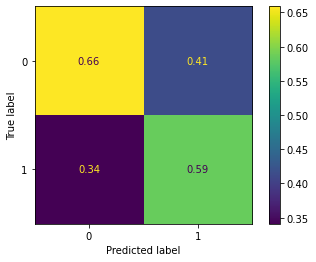

In [24]:
cm = confusion_matrix(y_test, y_pred_test_DT, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

## Features permutation

Since the performance are not clearly better than the LR, let's see what features are important for the RF. The following cell was copied from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html.

This cell mainly permute the features and see how the model refit them. 
It also check how much time it takes

DT hyperparameters tuning Model Accuracy 2: 63.67%
Elapsed time to compute the importances: 1.001 seconds


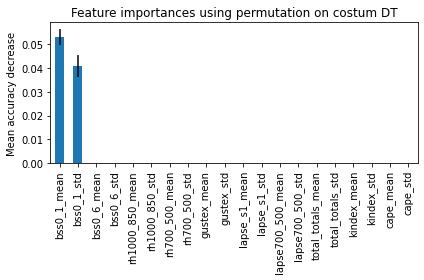

In [26]:
# Since HalvingGridSearchCV doesn't allow us to see the feature importance, 
# the a new model has to be retrained with the best estimators found previously 

dt_custom_2 = DecisionTreeClassifier(max_leaf_nodes=ls_be_DT[0],
                                     min_samples_leaf=ls_be_DT[1],
                                     max_depth=ls_be_DT[2],
                                     random_state=42)
dt_custom_2.fit(X_train,y_train)
prediction_dt_custom_2 = dt_custom_2.predict(X_train)
dt_custom_2_accuracy = accuracy_score(y_train, prediction_dt_custom_2)
print(f"DT hyperparameters tuning Model Accuracy 2: {dt_custom_2_accuracy:.2%}")

# Accuracy is a little worse then the previous one (dt_custom)
# Permutation of the features and see how the model refit them

start_time = time.time()
result_dt = permutation_importance(
    dt_custom_2, X_test, y_test, n_repeats=20, random_state=42, n_jobs=6
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

decision_tree_importances = pd.Series(result_dt.importances_mean, index=features_names)

# Let's see the resutls. The higher the bar is, the more important the feature is

fig, ax = plt.subplots()
decision_tree_importances.plot.bar(yerr=result_dt.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on costum DT")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# 4th algorithm: Gradient Boosting
